# Overview of the Problem
Gas turbines play a critical role in energy production, and the dynamic relationships between input control signals and output power responses are complex. Existing physical models often cannot accurately predict the entire behavior of the system or are too complex. This project aims to improve modeling accuracy and enhance decision support processes in energy systems by predicting turbine behavior using deep learning algorithms. The source of motivation is the lack of data-driven time series modeling in the literature and the need for precise predictions in the industry.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Dataset Description 
The dataset used in this project consists of eight separate CSV files, each corresponding to a different experimental run performed on a gas turbine system. The goal of these experiments is to observe how the gas turbine responds specifically its electrical power output after applying different input voltage excitation patterns.
The dataset is divided into:
Training Experiments (6 files) and Testing Experiments (2 files).

In [2]:
train_paths = [
    r"C:\Deep learning\Final project\train\ex_1.csv",
    r"C:\Deep learning\Final project\train\ex_9.csv",
    r"C:\Deep learning\Final project\train\ex_20.csv",
    r"C:\Deep learning\Final project\train\ex_21.csv",
    r"C:\Deep learning\Final project\train\ex_23.csv",
    r"C:\Deep learning\Final project\train\ex_24.csv"
]

test_paths = [
    r"C:\Deep learning\Final project\test\ex_4.csv",
    r"C:\Deep learning\Final project\test\ex_22.csv"
]

# Loading the dataset and checking

This function is responsible for loading a single CSV dataset and performing essential data integrity checks before the dataset is used for  modeling. Since each experiment is stored in a separate CSV file, this function ensures that every file is consistent, clean, and correctly formatted. 


In [5]:
def load_and_check(path):
    df = pd.read_csv(path)

    print(f"\n--- Checking: {path} ---")

    # Check missing values
    print("Missing values per column:")
    print(df.isnull().sum())

    if df.isnull().sum().sum() > 0:
        raise ValueError(f"Dataset {path} contains missing values!")

    # Check timestamp duplication: Time values must be unique in time-series data. 
    # Duplicate timestamps mean two samples occurred at the same time, which breaks temporal ordering and makes the series physically invalid.
    if df['time'].duplicated().any():
        raise ValueError(f"Dataset {path} contains duplicated timestamps!")

    # Ensure sorted by time
    df = df.sort_values(by="time").reset_index(drop=True)

    # Sampling rate check: This helps verify that the recording rate (sampling interval) is constant.
    # For this dataset, the theoretical sampling frequency is 1 second per sample.
    df['time_diff'] = df['time'].diff()
    sampling_mode = df['time_diff'].mode()[0]
    print(f"Median sampling interval: {df['time_diff'].median()} seconds")
    print(f"Most common interval: {sampling_mode} seconds\n")
    # Since time_diff was only needed to validate sample spacing, it is removed to keep the dataset clean.
    df.drop(columns=['time_diff'], inplace=True)

    return df

In [6]:
# Load datasets
train_dfs = [load_and_check(p) for p in train_paths]
test_dfs  = [load_and_check(p) for p in test_paths]

print("\nAll datasets successfully loaded and checked.")


--- Checking: C:\Deep learning\Final project\train\ex_1.csv ---
Missing values per column:
time             0
input_voltage    0
el_power         0
dtype: int64
Median sampling interval: 0.9990999999999985 seconds
Most common interval: 0.9990999999999985 seconds


--- Checking: C:\Deep learning\Final project\train\ex_9.csv ---
Missing values per column:
time             0
input_voltage    0
el_power         0
dtype: int64
Median sampling interval: 1.0 seconds
Most common interval: 1.0 seconds


--- Checking: C:\Deep learning\Final project\train\ex_20.csv ---
Missing values per column:
time             0
input_voltage    0
el_power         0
dtype: int64
Median sampling interval: 1.0599999999994907 seconds
Most common interval: 1.0 seconds


--- Checking: C:\Deep learning\Final project\train\ex_21.csv ---
Missing values per column:
time             0
input_voltage    0
el_power         0
dtype: int64
Median sampling interval: 1.0399999999999636 seconds
Most common interval: 1.0 seconds

# Gas Turbine Time-Series Visualization 
The goal is to inspect how the gas turbine system responds under different experimental conditions, identify trends or patterns in the data, and gain an initial understanding of the system behavior before the model development. Through visualizing their time-series signals by plotting input voltage and electrical power against time.

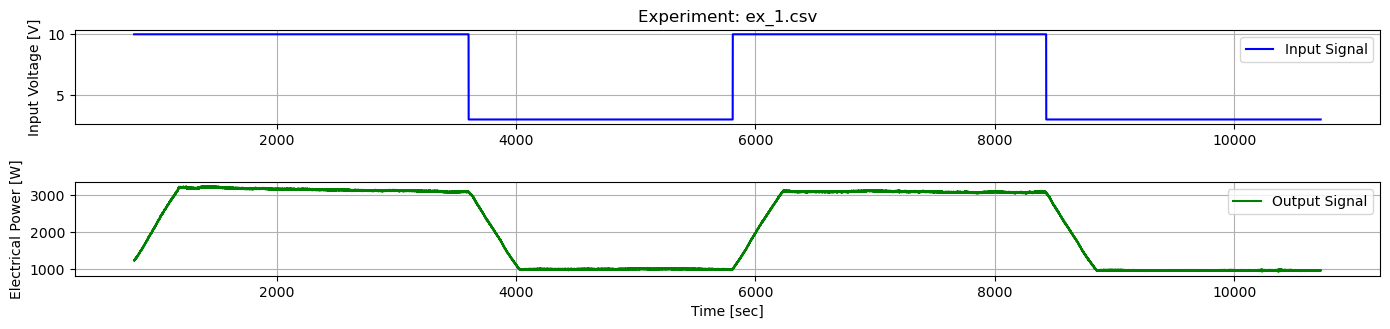

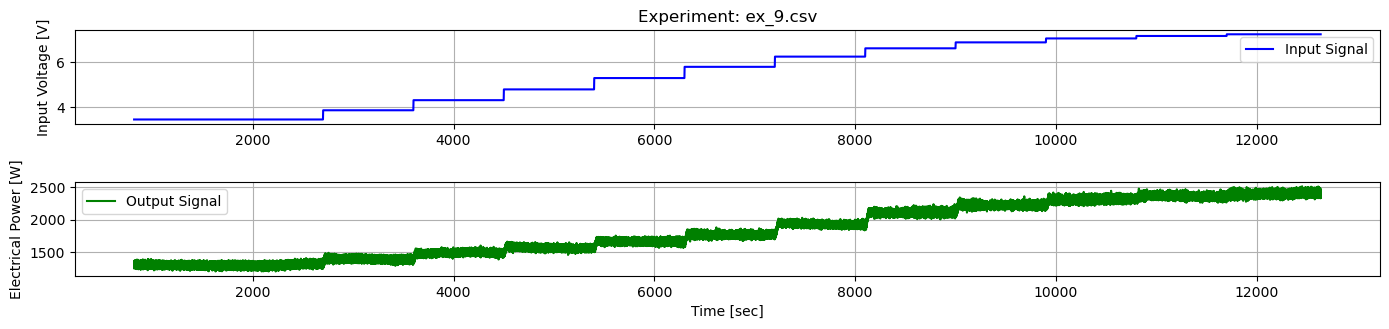

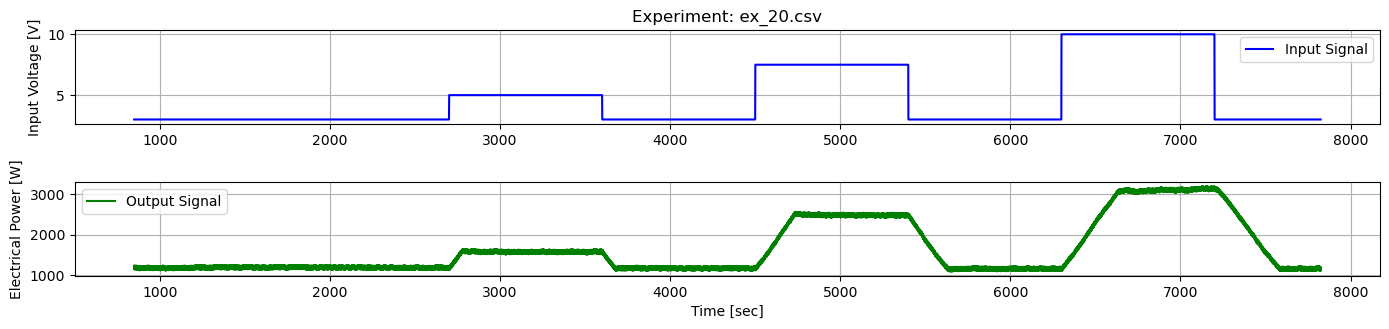

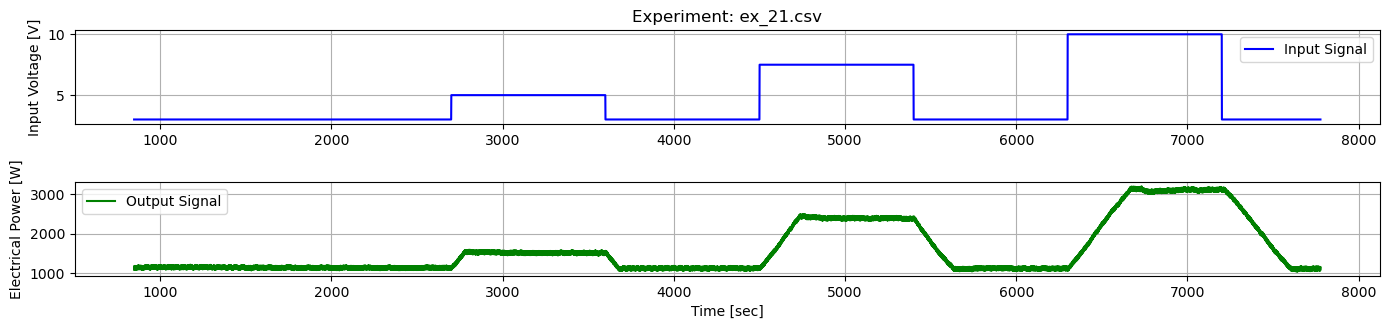

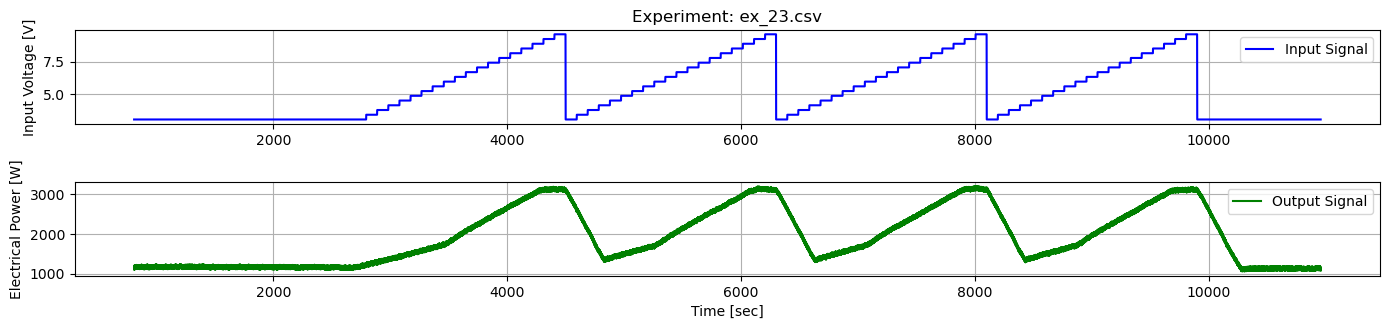

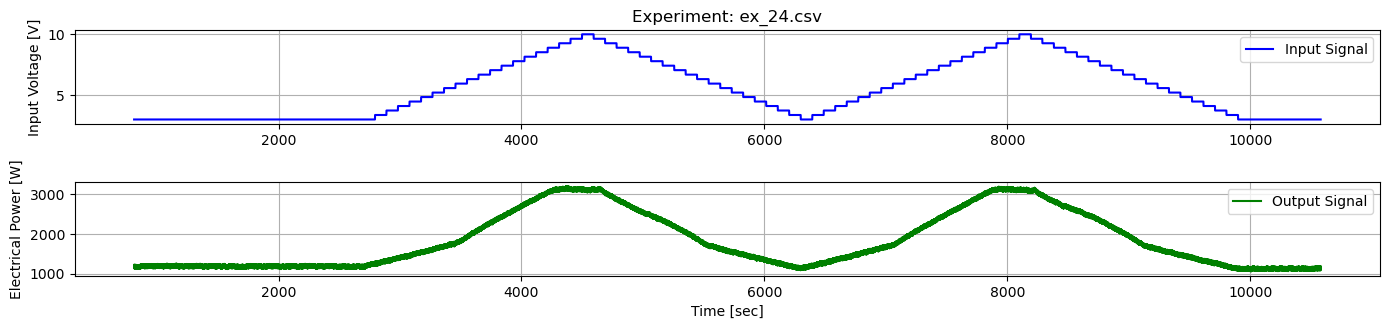

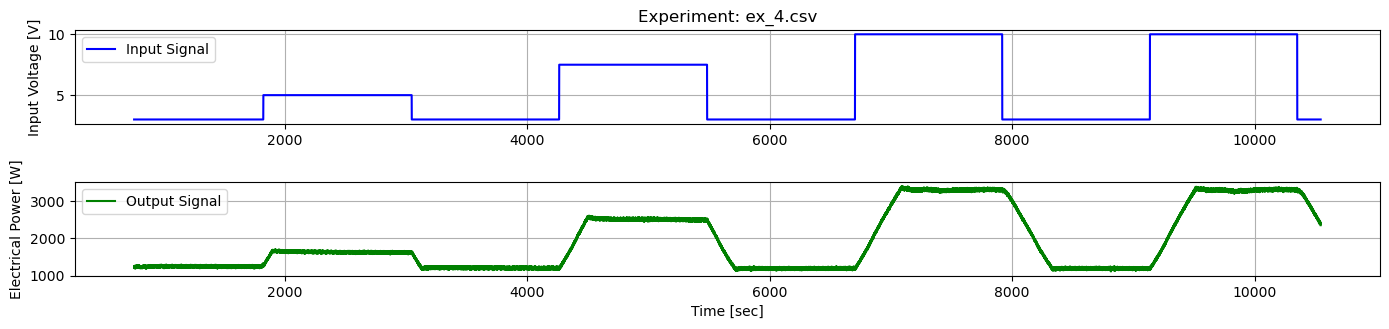

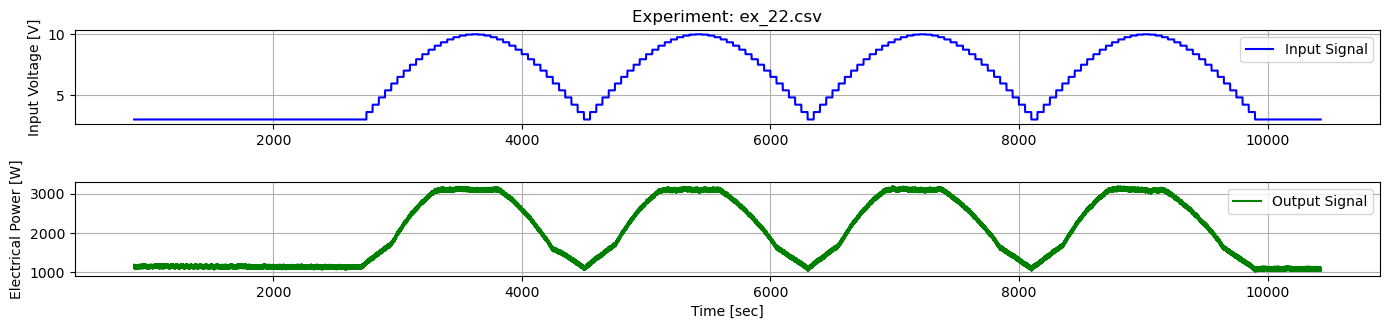

In [44]:
all_paths = [
    r"C:\Deep learning\Final project\train\ex_1.csv",
    r"C:\Deep learning\Final project\train\ex_9.csv",
    r"C:\Deep learning\Final project\train\ex_20.csv",
    r"C:\Deep learning\Final project\train\ex_21.csv",
    r"C:\Deep learning\Final project\train\ex_23.csv",
    r"C:\Deep learning\Final project\train\ex_24.csv",
    r"C:\Deep learning\Final project\test\ex_4.csv",
    r"C:\Deep learning\Final project\test\ex_22.csv"
]

for path in all_paths:
    df = pd.read_csv(path)
    
    plt.figure(figsize=(14,6))
    
    # Input voltage
    plt.subplot(4,1,1)
    plt.plot(df['time'], df['input_voltage'], color='blue', label='Input Signal')
    plt.ylabel("Input Voltage [V]")
    plt.title(f"Experiment: {path.split('\\')[-1]}")
    plt.legend()
    plt.grid(True)
    
    # Electrical power
    plt.subplot(4,1,2)
    plt.plot(df['time'], df['el_power'], color='green', label='Output Signal')
    plt.ylabel("Electrical Power [W]")
    plt.xlabel("Time [sec]")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


# Statistical Summary
This section combines all loaded training datasets into a single DataFrame and computes basic statistical summaries
(mean, standard deviation, min, max etc...) for the main variables "input_voltage" and "el_power". 

In [46]:
all_train_raw = pd.concat(train_dfs, axis=0)
print("\n--- Statistical Summary (Training Data) ---")
print(all_train_raw[['input_voltage', 'el_power']].describe())


--- Statistical Summary (Training Data) ---
       input_voltage      el_power
count   52940.000000  52940.000000
mean        5.505534   1843.315949
std         2.549721    723.126377
min         3.000000    932.837260
25%         3.000000   1205.743900
50%         4.842105   1605.753998
75%         7.421053   2399.419112
max        10.000000   3249.891217


# Distribution Visualization
Plot histograms with to visualize the distribution and overall density of 'input_voltage' and 'el_power' in the training data


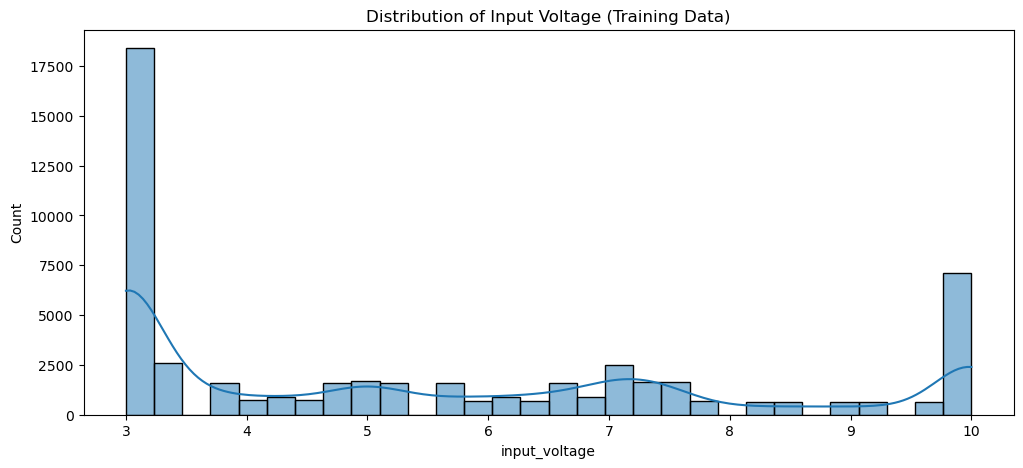

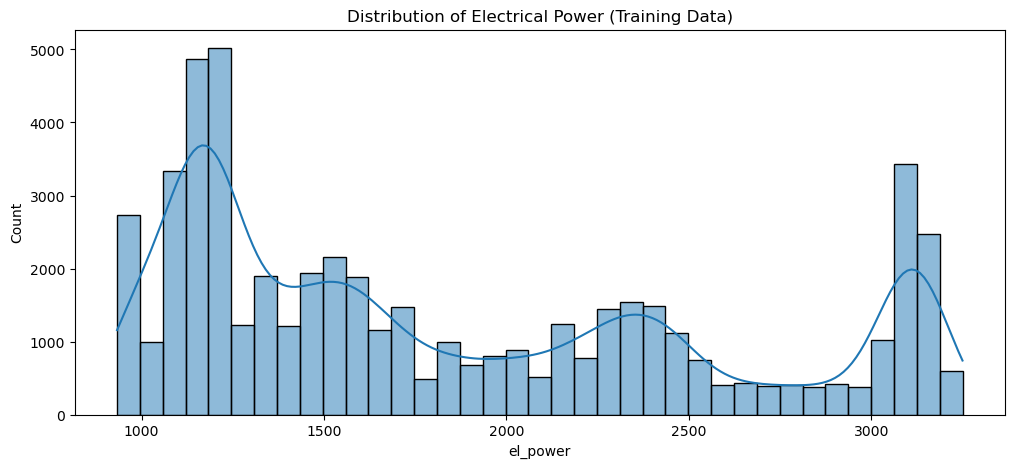

In [47]:
plt.figure(figsize=(12, 5))
sns.histplot(all_train_raw['input_voltage'], kde=True)
plt.title("Distribution of Input Voltage (Training Data)")
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(all_train_raw['el_power'], kde=True)
plt.title("Distribution of Electrical Power (Training Data)")
plt.show()

# Correlation Analysis
Compute and visualize the correlation matrix between 'input_voltage' and 'el_power' using a heatmap


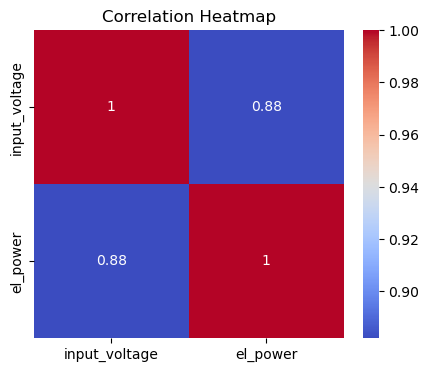


Correlation Matrix:
               input_voltage  el_power
input_voltage       1.000000  0.882142
el_power            0.882142  1.000000


In [48]:
corr = all_train_raw[['input_voltage', 'el_power']].corr()

plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

print("\nCorrelation Matrix:")
print(corr)